<a href="https://colab.research.google.com/github/tishakbhavsar/practising-pytorch/blob/main/02_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-Class Classification Problem

In [72]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
# Device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Creating a toy multi-class *dataset*

In [ ]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

In [ ]:
# Turn into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [ ]:
# Split

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

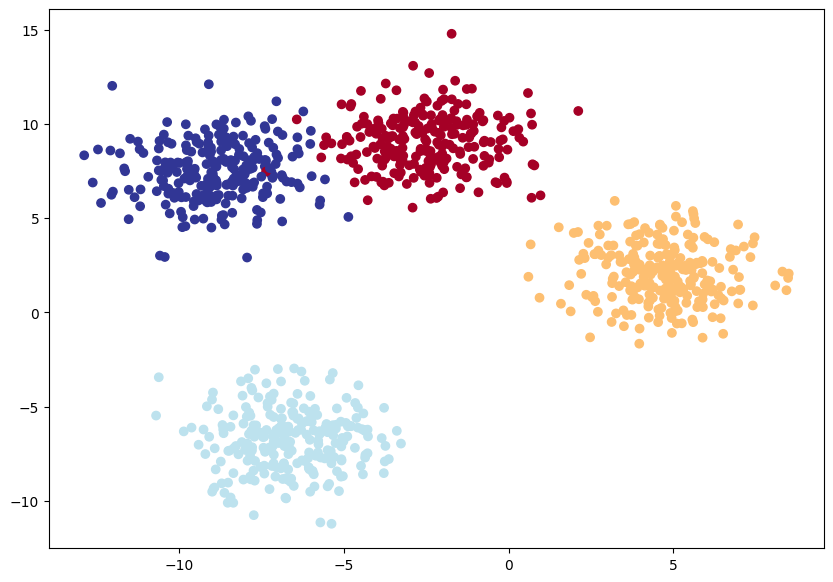

In [ ]:
# Plot the data

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);

### Building the Model

In [ ]:
class MultiClassModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    """Initializes multi-class classification model.

    Agrs:
       input_features(int): Number of input features to the model
       output_features(int): Number of output features of the model
       hidden_units(int): Number of hidden units between input and output layers of the model (default->8)

    Returns:
       None
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [ ]:
# Creating an instance

model = MultiClassModel(input_features=2, output_features=4, hidden_units=8).to(device)

In [ ]:
model

MultiClassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

#### Create loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss() # if we have imbalanced classes, can use the weight parameter!
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

### Logits and stuff

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then into prediction labels.

In [ ]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_pred_labels = torch.argmax(y_pred_probs, dim=1) #that class index with highest prob

y_logits[:2]


tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010]])

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#### Training and testing loop

In [ ]:
# Put data on device:

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

EPOCHS = 100

for epoch in range(EPOCHS):
  model.train()

  y_logits = model(X_train).squeeze()
  y_preds = torch.argmax(torch.softmax(y_logits,dim=1),dim=1)

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_preds = torch.argmax(torch.softmax(test_logits,dim=1),dim=1)
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_preds)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04324 | Acc: 65.50% | Test Loss: 0.57861 | Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398 | Acc: 99.12% | Test Loss: 0.13037 | Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062 | Acc: 99.12% | Test Loss: 0.07216 | Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924 | Acc: 99.12% | Test Loss: 0.05133 | Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892 | Acc: 99.00% | Test Loss: 0.04098 | Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295 | Acc: 99.00% | Test Loss: 0.03486 | Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910 | Acc: 99.00% | Test Loss: 0.03083 | Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643 | Acc: 99.00% | Test Loss: 0.02799 | Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448 | Acc: 99.00% | Test Loss: 0.02587 | Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300 | Acc: 99.12% | Test Loss: 0.02423 | Test Acc: 99.50%


In [ ]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_pred_labels = torch.argmax(y_pred_probs, dim=1) #that class index with highest prob
  print(f"Test acc: {accuracy_fn(y_test,y_pred_labels)}%")

Test acc: 99.5%


In [ ]:
import requests
from pathlib import Path

# Download helper functions from the repo

if Path("helper_functions.py").is_file():
  print("it exists!")
else:
  print("Download helper functions from Github!")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

it exists!


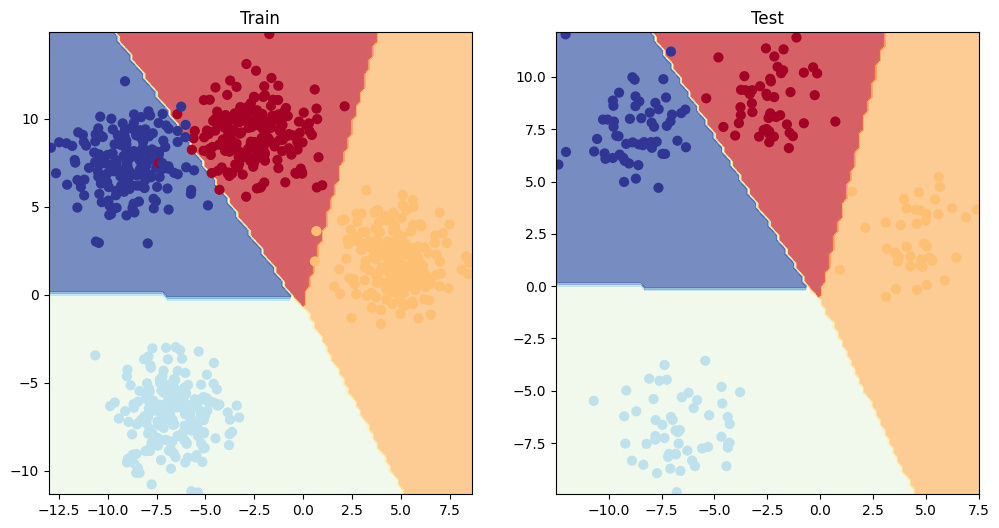

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

### Non-linearity is not needed here, after removing ReLU also its done!

## 9. More Classification Metrics

In [ ]:
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [ ]:
classification_rep = classification_report(y_test, y_pred_labels)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        53
           3       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200



In [ ]:
cm = confusion_matrix(y_test, y_pred_labels)
cm

array([[49,  0,  0,  0],
       [ 0, 41,  0,  0],
       [ 0,  0, 53,  0],
       [ 1,  0,  0, 56]])

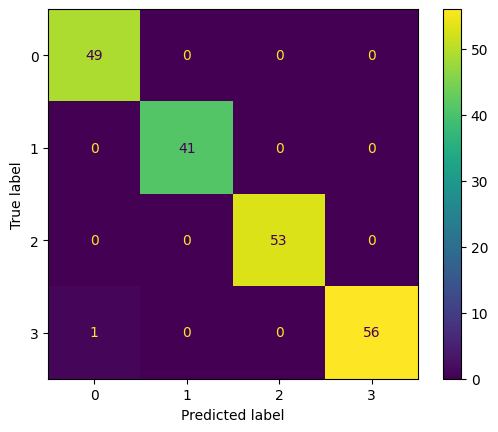

In [ ]:
ConfusionMatrixDisplay(cm).plot()

## Use Torch Metrics

In [ ]:
from torchmetrics import Accuracy

accuracy = Accuracy(task="multiclass", num_classes=4)
accuracy_value = accuracy(y_pred_labels, y_test).item()
print("ACCURACY:" , accuracy_value)

ACCURACY: 0.9950000047683716
